In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("ps10.ipynb")


# Problem Set 10
## Logistic regression, automatic differentiation, and neural networks

In this problem set you will study binary classification, logistic regression, and implement a simple neural network with one hidden layer.

For data in this problem set, we will use the MNIST data set which we saw on problem set 6. To make things run faster, we will only use the first 1000 images in the data set:

In [2]:
import numpy
mnist = numpy.load('mnist.npz')
X = mnist['images'][:1000]
y = mnist['labels'][:1000]
n, p = X.shape


## Question 1: Binary classification

In this exercise you will use `sklearn` to build a binary classifier.

In [3]:
import sklearn
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.linear_model
import numpy as np


The classifier will take as input a $28\times 28$ grayscale MNIST image, and return `1` if the image represents the number 5, and `0` otherwise.

*Note*: various algorithms implemented in `sklearn` are randomized. To utilize the same randomness as we did when generating the solutions (and hence, to ensure that your output passes the test cases), use `random_state=1` wherever necessary when calling `sklearn` methods.

**1(a)** (1 pt) Using the `mnist` data loaded above, create a standardized version of `X` where each column has zero mean and variance one. (Hint: use the `sklearn.preprocessing` module.)

In [88]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
Xs = scaler.transform(X)

In [90]:
grader.check("1a")


1a results: All test cases passed!

**1(b)** (1 pt) Using the `mnist` data loaded above, create a vector `y5` which equals `1` if the the corresponding MINST image equals is of the number 5, and `0` otherwise.

In [91]:
y5 = (y == 5).astype(int)

In [92]:
grader.check("1b")


1b results: All test cases passed!

**1(c)**(1pt) Using `sklearn.model_selection.train_test_split`, divide the data into 70% training data and 30% test data. To ensure that your output matches our tests, pass the option `random_state=1` into the method.

In [93]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    Xs, y5, random_state=1, test_size=0.3)


In [94]:
grader.check("1c")


1c results: All test cases passed!

**1(d)**(2pt) Use `sklearn.linear_model.LogisticRegression` to train a binary classifier on the *training data only*. 

In [95]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty="l2")
clf.fit(X_train,y_train)

LogisticRegression()

In [96]:
grader.check("1d")

1d results: All test cases passed!

<!-- BEGIN QUESTION -->

**1(e)**(1pt) How accurate is your trained classifier on `X_train`/`y_train`? How accurate is it on `X_test`/`y_test`? (Use whatever measure of accuracy you think is appropriate.)

In [97]:
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

1.0
0.9466666666666667


In [98]:
from sklearn.metrics import zero_one_loss

print(zero_one_loss(clf.predict(X_train), y_train))
print(zero_one_loss(clf.predict(X_test), y_test))

0.0
0.053333333333333344


Using log-loss to check the accuracy, for X_train/y_train, it's 0 misclassification rate.  for X_test/y_test, it's about five-percent misclassification rate. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**1(f)**(2pt) The regularization parameter can be varied by setting `LogisticRegression(C=C)` , where `C` is the value of the regularization penalty. What happens to the test error that you computed in the previous step as you vary `C`? Can you find a setting of `C` that results in lower test error than the default value `C=1`?

The C parameter controls the amount of regularization in the LogisticRegression object: a large value for C results in less regularization.  A high value of C tells the model to give high weight to the training data, and a lower weight to the complexity penalty. A low value tells the model to give more weight to this complexity penalty at the expense of fitting to the training data. 

Based on the figure below, when C=0.1, the test error is lower than C=1.

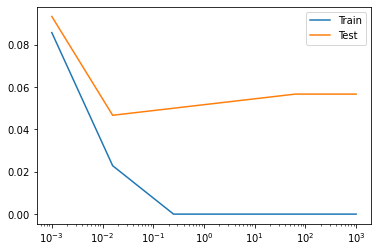

[0.09333333333333338, 0.046666666666666634, 0.050000000000000044, 0.053333333333333344, 0.05666666666666664, 0.05666666666666664]


In [99]:
import matplotlib.pyplot as plt
C_list = np.logspace(-3,3,num=6)
train = []
test = []
for i in C_list:
  clf = sklearn.linear_model.LogisticRegression(C=i)
  clf.fit(X_train, y_train)


  train.append( 1-clf.score(X_train, y_train) )
  test.append( 1-clf.score(X_test, y_test) )


plt.semilogx(C_list, train, label='Train')
plt.semilogx(C_list, test, label='Test')
plt.legend()
plt.show()

print(test)

<!-- END QUESTION -->

## Question 2
In lecture we learned that logistic regression assumes the probability model 

$$\mathbb{P}(y_i=1\mid \mathbf{x}_i) = \sigma(\mathbf{x}_i^T\boldsymbol{\beta}),$$ 

where $\mathbf{x}_i$ are rows of the data matrix $\mathbf{X}\in\mathbb{R}^{n\times p}$, $\mathbf{y}\in\{0,1\}^n$ is a vector of binary responses, and

$$\sigma(a)=\frac{1}{1+\exp(-a)}$$ 

is a *sigmoid* function which maps  real numbers into the interval $[0,1]$.

Logistic regression tries to find $\hat{\boldsymbol{\beta}}$ that maximizes the (log)likelihood of the data. However, in complex data sets, the linear mapping $\mathbf{x}_i\mapsto \mathbf{x}_i^T \boldsymbol{\beta}$ may not be complex enough to form a good classifier. 

This exercise will walk you through the process of building a more complex classifier: a one-layer feedforward neural network, known as a [multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron). To implement this, we will use the machine learning library JAX:

In [100]:
import jax

JAX includes a Numpy-like interface:

In [101]:
import jax.numpy as jnp


You should use the `jnp` library for all array manipulations in this question.

**2(a)**(2pt) Define a *neuron* to be a function that takes three arguments: an *input* vector $x\in\mathbb{R}^p$, a *weight vector* $w \in \mathbb{R}^p$, and a *bias* $b\in \mathbb{R}$. The neuron should return `1` if $w^T x > b$ and `0` otherwise.

In [102]:
def neuron(x, w, b):
    return (w.dot(x)-b>0).astype(int)


In [103]:
grader.check("2a")


2a results: All test cases passed!

**2(b)**(2pt) The `neuron()` function you wrote in the previous step models the behavior of an actual neuron in the brain. However, it is difficult to work with computationally because it jumps suddenly from 0 to 1 as soon as $w^Tx-b>0$. 

Define a second function, `smooth_neuron(x, w, b)`, which takes the same arguments and returns $\sigma(x^T w - b)$, where $\sigma$ is the sigmoid function defined above. In what sense is the `smooth_neuron` function an approximation to `neuron` function?

In [104]:
def smooth_neuron(x, w, b):
    return jax.nn.sigmoid(w.dot(x)-b)


In [105]:
grader.check("2b")


2b results: All test cases passed!

**2(c)**(2pt) Define function `hidden_layer(x, W, b)` which accepts three parameters:
  - An input vector $x\in\mathbb{R}^p$;
  - A weight matrix $W\in\mathbb{R}^{K\times p}$
  - A bias vector $b \in \mathbb{R}^{K}$.
The output of `hidden_layer(x, W, b)` should be a vector `h` of dimension `K`, whose `i`-th entry is:
```
h[i] = smooth_neuron(x, w[i], b[i]).
```

*Note*: don't use for loops in your implementation. Instead, use `jax.vmap` as shown in lecture.

In [106]:
from jax import vmap

In [107]:
def hidden_layer(x, W, b):
    f = vmap(smooth_neuron, in_axes=(None, 0, 0))
    return f(x, W, b)


In [108]:
grader.check("2c")


2c results: All test cases passed!

**2(d)**(2pt)
The MLP is completed by passing the output of the hidden layer through a final neuron. Mathematically, given the $h$ vector returned from the `hidden_layer` function defined above, the MLP returns 

$$\text{mlp}(x) = \sigma(h^T w_0 + b_0),$$

where $w_0\in\mathbb{R}^K$ and $b_0\in\mathbb{R}$

In [109]:
def mlp(params, x):
    '''
    Multi-layer perceptron.

    Args:
        params: a dict with four entries:
            W, b: arguments to the `hidden_layer` function.
            w0, b0: K-dimensional arguments to the smooth_neuron function
        x: the input

    Returns:
        mlp evaluated on input x, i.e. the probability that the class label y=1 given x.

    Note:
        The number of hidden units is controlled by the dimension of W, b, w0, b0.
    '''
    h = hidden_layer(x, params['W'], params['b'])
    return jax.nn.sigmoid(h.dot(params['w0'])-params['b0'])


In [110]:
grader.check("2d")


2d results: All test cases passed!

**2(e)**(4pt) Define a function `mlp_loss(params, X, y)` which takes three arguments: a `params` dict, which will be passed to the `mlp` function, a matrix $X$ of features, and a vector $y\in\{0,1\}$ of class labels. The function should return the negative log-likelihood of the data when they are classified using the a binary classifier based on the given MLP.

In [111]:
from jax.scipy.special import xlogy, xlog1py

In [112]:
def mlp_loss(params, X, y):
  vmlp = jax.vmap(mlp, in_axes=[None,0])
  p = jnp.clip(vmlp(params, X), 1e-8, 1-1e-8)
  loss = -jnp.sum(xlogy(y, p) + xlog1py(1 - y, -p))
  return loss

In [113]:
grader.check("2e")


2e results: All test cases passed!

<!-- BEGIN QUESTION -->

**2(f)** How long does it take you to evaluate `mlp_loss` for the entire MNIST dataset? What about if you transform `mlp_loss` using `@jax.jit` first?

In [114]:
X = mnist['images']
y = mnist['labels']
params = {'W' : jnp.array([[1.0], [2.0], [3.0], [4.0]]), 
                      'b' : jnp.array([13.0, -8.0, 10.5, 1.0]), 
                      'w0' : jnp.array([1.0, -1.0, 0.0, 0.0]), 
                      'b0' : 3.0}

params['W'] = jnp.tile(params['W'], (1, X.shape[1]))

In [115]:
%%time
mlp_loss(params, jnp.array(X), jnp.array(y))

CPU times: user 106 ms, sys: 95.1 ms, total: 201 ms
Wall time: 95.6 ms


DeviceArray(1393392.5, dtype=float32)

In [116]:
@jax.jit
def new_mlp(params,X,y):
    return mlp_loss(params, jnp.array(X), jnp.array(y))

In [117]:
%%time
new_mlp(params,X,y)

CPU times: user 93.1 ms, sys: 7.4 ms, total: 100 ms
Wall time: 99.6 ms


DeviceArray(1393392.5, dtype=float32)

With @jax.jit it is much faster.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**2(g)** (For fun) Train the multi-layer perceptron such that it has better (lower) test error on the classification problem from Question 1 compared to ordinary logistic regression.

*Hints*: 
- Training will be exceptionally slow unless you make use of gradients via the `@jax.grad` and/or `@jax.value_and_grad` transformations. (Be sure to jit these calls as well.)
- You will likely need to add a regularization term to the loss function.
- `jax.scipy.optimize.minimize` can be used to easily train the model.

_Type your answer here, replacing this text._

<!-- END QUESTION -->



---

To double-check your work, the cell below will rerun all of the autograder tests.

In [118]:
grader.check_all()


1a results: All test cases passed!

1b results: All test cases passed!

1c results: All test cases passed!

1d results:
    1d - 1 result:
        Trying:
            assert sum(clf.predict(X_test)) == 27
        Expecting nothing
        **********************************************************************
        Line 1, in 1d 0
        Failed example:
            assert sum(clf.predict(X_test)) == 27
        Exception raised:
            Traceback (most recent call last):
              File "/opt/homebrew/anaconda3/envs/math/lib/python3.8/doctest.py", line 1336, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest 1d 0[0]>", line 1, in <module>
                assert sum(clf.predict(X_test)) == 27
            AssertionError

2a results: All test cases passed!

2b results: All test cases passed!

2c results: All test cases passed!

2d results: All test cases passed!

2e results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

Upload this .zip file to Gradescope for grading.

In [119]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)
